In [287]:
import os
import numpy as np
import pyqubo as pq
import sympy as sp
import pandas as pd
import seaborn as sns

from PyQubo_formulation import *
from Utilities import *

import neal
import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [125]:
root = np.array([0,4], dtype='float')

ulen = 6

# eps1 = np.around(np.random.uniform(-0.5, 0.5, ulen), decimals=2)
eps2 = np.around(np.random.uniform(-1, 1, ulen), decimals=2)

domains = np.tile(root, (ulen,1))

# domains[:,0] = domains[:,0]+eps1
domains[:,1] = domains[:,1]+eps2


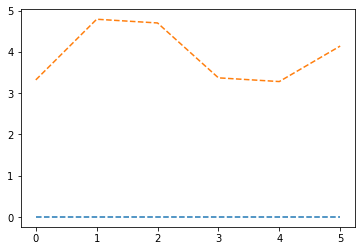

In [126]:
plt.plot(domains[:,0], '--')
plt.plot(domains[:,1], '--')
plt.show()

In [203]:
p = [1,1,1,1,1,1]
float_approx(p, domains[1])

4.71515625

In [127]:
nq_u = 6
u = Create_float_vec(ulen, nq_u, domains)
u[0]

(1.660000 * (((((Binary('q[0]') + (0.500000 * Binary('q[1]'))) + (0.250000 * Binary('q[2]'))) + (0.125000 * Binary('q[3]'))) + (0.062500 * Binary('q[4]'))) + (0.031250 * Binary('q[5]'))))

In [128]:
empty = np.sum(u).compile()
og_vars = empty.variables
print(og_vars)

['q[0]', 'q[1]', 'q[2]', 'q[3]', 'q[4]', 'q[5]', 'q[6]', 'q[7]', 'q[8]', 'q[9]', 'q[10]', 'q[11]', 'q[12]', 'q[13]', 'q[14]', 'q[15]', 'q[16]', 'q[17]', 'q[18]', 'q[19]', 'q[20]', 'q[21]', 'q[22]', 'q[23]', 'q[24]', 'q[25]', 'q[26]', 'q[27]', 'q[28]', 'q[29]', 'q[30]', 'q[31]', 'q[32]', 'q[33]', 'q[34]', 'q[35]']


In [129]:
nq_mu = 6

muparams = np.array([nq_mu,[0,4]], dtype=object)

In [199]:
maxnorm = Max_Norm_LP(u, 2, muparams, muparams)

model = maxnorm.compile(strength=10)

model_qubo = model.to_qubo(index_label=True)

np.trace(Dict_to_Mat(model_qubo[0]))

4491.78234956867

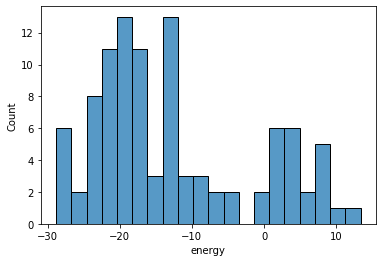

In [200]:
sampler = neal.SimulatedAnnealingSampler()

correct_max = np.max(domains)

model_qubo = model.to_qubo()
    
sampleset = sampler.sample_qubo(model_qubo[0], num_reads=100)

samples = sampleset.samples()

data = sampleset.to_pandas_dataframe()


cwd = os.getcwd()
path = cwd + "/Data/SA/"

data.to_hdf(path+'trialsave.h5', key='a', mode='w')

sns.histplot(data['energy'], bins=20)
plt.show()

In [201]:
low_samps = np.argwhere(sampleset.record['energy'] < np.min(sampleset.record['energy'])+1 ).flatten()

print(low_samps)

strings = np.zeros((len(low_samps),len(og_vars)))

for i in range(len(low_samps)):
    for j in range(len(og_vars)):
        strings[i][j] = samples[int(low_samps[i])][og_vars[j]]
strings


[24 31 94 98]


array([[1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 0.],
       [1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
        0., 1., 1., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
        0., 0., 1., 1.]])

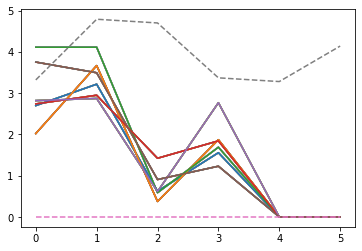

In [202]:
## subbing back into binary approximation to get the result

res = np.zeros((nq_u, ulen))
for n in range(len(strings)):
    for i in range(ulen):
        res[n][i] = float_approx(strings[n][i*nq_u : nq_u*(i+1),], domains[i])

for r in res:
    plt.plot(res)
plt.plot(domains[:,0], '--')
plt.plot(domains[:,1], '--')
plt.show()

In [304]:
sampler = neal.SimulatedAnnealingSampler()

gamma = np.linspace(1,40,20)


results = []
for i in range(len(gamma)):
    
    maxnorm = Max_Norm_LP(u, gamma[i], muparams, muparams)

    model = maxnorm.compile(strength=30)
    
#     model_vars = model.variables
#     unique_vars = model_vars[:(nq_u*ulen+2*nq_mu)]

    model_qubo = model.to_qubo()
    
    sampleset = sampler.sample_qubo(model_qubo[0], num_reads=1000)

    samples = sampleset.samples()
    energies = sampleset.record['energy']

    data = sampleset.to_pandas_dataframe()

    cwd = os.getcwd()
    path = cwd + "/Data/SA/"

    data.to_hdf(path+'trialgamma{}.h5'.format(gamma[i]), key='a', mode='w')

    
#     min_energy = np.min(energies)

#     errors = np.zeros(len(samples))
#     for j in range(len(samples)):
#         if np.abs(min_energy - energies[j]) <= np.abs(min_energy)/100:
#             results.append(samples[j])


In [305]:
pd.read_hdf(path+'trialgamma1.h5')

,kq[0],kq[1],kq[2],kq[3],kq[4],kq[5],muq[0],muq[1],muq[2],muq[3],...,q[7] * q[9],q[8],q[8] * q[10],q[8] * q[11],q[8] * q[9],q[9],q[9] * q[10],q[9] * q[11],energy,num_occurrences
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,5.654684,1
1,0,0,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,19.168104,1
2,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,1,1,1,16.638422,1
3,0,1,0,1,1,0,1,0,1,0,...,0,0,0,0,0,1,1,1,10.006206,1
4,0,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,1,25.615648,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,1,1,...,0,1,1,1,1,1,1,1,4.010739,1
996,0,0,0,1,0,0,1,1,0,1,...,1,1,1,0,1,1,1,0,27.992217,1
997,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,4.240878,1
998,1,0,0,1,0,0,1,1,0,1,...,0,1,1,0,0,0,0,0,6.205487,1


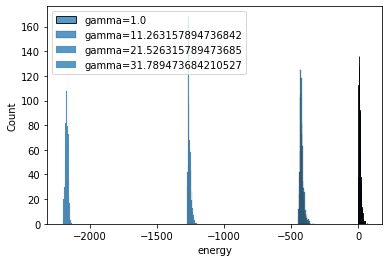

In [308]:
for i in range(4):
    frame = pd.read_hdf(path+'trialgamma{}.h5'.format(gamma[5*i]))
    sns.histplot(frame['energy'], label='gamma={}'.format(gamma[5*i]))
plt.legend()
plt.show()

In [309]:
all_vars = frame.iloc[20].keys()[:140-2]
frame.iloc[min_e]['q[0] * q[1]']

0.0

In [310]:
res = []
sample = []
for s in range(len(gamma)):
    frame = pd.read_hdf(path+'trialgamma{}.h5'.format(gamma[s]))

    min_e = np.argmin(frame['energy'])
    
    sample.append(frame.iloc[min_e])
    
#     min_e_all.append(frame.iloc[min_e][all_vars])#dont need actually
    
    min_e_samps = list(frame[og_vars].iloc[min_e])
    
    res.append(min_e_samps)
print(sample[0]['q[0]'])

0.0


In [321]:
# compute quad error and maxnorm error for each gamma so for each entry 
# of sample and res, respectively.

ceiling = np.max(domains, axis=1)

q_error, problematic = [], [] 

error = []

result = np.zeros((len(gamma),ulen))

for i in range(len(gamma)):
    
    q_er, prob, _ = quad_error(sample[i], og_vars)
    q_error.append(q_er)
    problematic.append(prob)
    
    
    for j in range(ulen):
        result[i][j] = float_approx(res[i][j*nq_u : nq_u*(j+1)], domains[j])
    
    error.append((np.abs(result[i] - ceiling)) / ceiling)

result

array([[0.051875  , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.2075    , 0.4490625 , 0.2203125 , 0.210625  , 0.205     ,
        0.25875   ],
       [2.905     , 1.9459375 , 4.1125    , 2.89609375, 3.02375   ,
        3.2990625 ],
       [2.956875  , 4.19125   , 4.1125    , 3.00140625, 2.9725    ,
        3.751875  ],
       [2.905     , 4.19125   , 4.1125    , 3.00140625, 2.9725    ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.10671875, 3.075     ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.159375  , 3.075     ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.159375  , 3.075     ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.159375  , 3.075     ,
        3.6871875 ],
       [3.1125    , 4.19125   , 4.1125    , 3.31734375, 3.075     ,
        3.6871875 ],
       [3.268125  , 4.19125   , 4.1125    , 3.31734375, 3.075     ,
        3.6871875 ],
       [3.268125  , 4

In [292]:
np.max(domains, axis=1)

array([3.32, 4.79, 4.7 , 3.37, 3.28, 4.14])

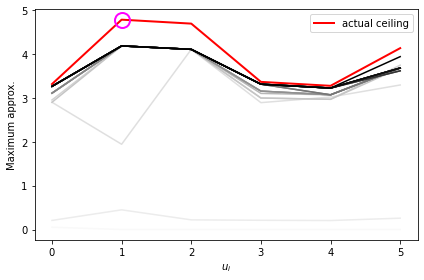

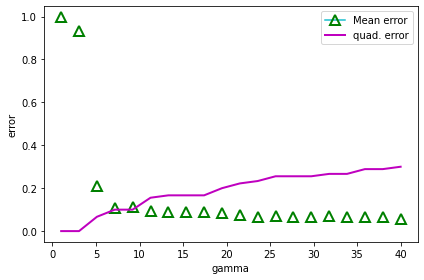

In [392]:
# plt.plot(gamma, error)
cNorm = colors.Normalize(vmin=0, vmax=gamma[-1])
cm = plt.get_cmap('binary')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


plt.plot(ceiling, c='r', lw=2, label='actual ceiling')
for i in range(len(result)):

    plt.plot(result[i], color=scalarMap.to_rgba(gamma[i]))
# plt.plot(error[-1])
plt.ylabel('Maximum approx.')
plt.xlabel(r'$u_i$')
plt.plot(1, np.max(domains), marker="o", markersize=15, markeredgecolor="magenta",
markerfacecolor="None", markeredgewidth=2)


plt.legend()
plt.tight_layout()
plt.savefig('simple_maxnorm_test.png', dpi=300)
plt.show()

for i in range(len(result[:-1])):
    plt.plot(gamma[i], np.mean(error[i]), marker="^", markersize=10, markeredgecolor="green",
        markerfacecolor="None", markeredgewidth=2)

plt.plot(gamma[-1], np.mean(error[-1]), marker="^", markersize=10, markeredgecolor="green",
        markerfacecolor="None", markeredgewidth=2, label='Mean error')
plt.plot(gamma, q_error, c='m', lw=2, label='quad. error')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('error')
plt.tight_layout()
plt.savefig('simple_maxnorm_test__errors.png', dpi=300)
plt.show()

In [30]:
import dimod

sampler_exact = dimod.ExactSolver()
sampler_exact.parameters

model_bqm = dimod.BQM.from_qubo(model_qubo[0])

In [31]:
sampleset = sampler_exact.sample(model_bqm)

samples = sampleset.samples()
energies = sampleset.record['energy']

errors = np.zeros(len(samples))
for j in range(len(samples)):
    errors[j] = quad_error(samples[j], quad_vars)


median = np.median(errors)
mean = np.mean(errors)


ValueError: Maximum allowed dimension exceeded

In [10]:
# Dimond doesn't work so look at SA again

import neal

sampler = neal.SimulatedAnnealingSampler()

sampler.parameters

{'beta_range': [],
 'num_reads': [],
 'num_sweeps': [],
 'beta_schedule_type': ['beta_schedule_options'],
 'seed': [],
 'interrupt_function': [],
 'initial_states': [],
 'initial_states_generator': []}

In [13]:
M = np.linspace(1, 20, 40)

median = np.zeros(len(M))
mean = np.zeros(len(M))

energies = np.zeros(len(M), dtype='object')
samples = np.zeros(len(M), dtype='object')

for i in range(len(M)):
    
    maxnorm = Max_Norm_LP(u, M[i], muparams, muparams)
    
    model = maxnorm.compile(strength=5)

    model_qubo = model.to_qubo()
    
    sampleset = sampler.sample_qubo(model_qubo[0], num_reads=1000)

    samples[i] = sampleset.samples()
    energies[i] = sampleset.record['energy']

#     errors = np.zeros(len(samples))
#     for j in range(len(samples)):
#         errors[j] = quad_error(samples[j], quad_vars)
    
#     plt.plot(errors, color=scalarMap.to_rgba(M[i]))
    
#     median[i] = np.median(errors)
#     mean[i] = np.mean(errors)

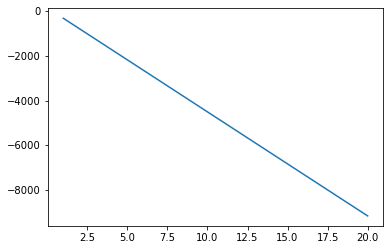

In [21]:
min_e = np.zeros(len(energies))

for i in range(len(energies)):
    min_e[i] = np.min(energies[i])
plt.plot(M, min_e)
plt.show()

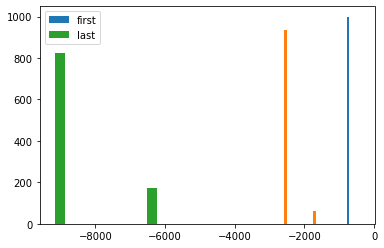

In [38]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

cNorm = colors.Normalize(vmin=1, vmax=M[-1])
cm = plt.get_cmap('hot_r')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.hist(energies[1], label='first')
plt.hist(energies[10])
plt.hist(energies[39], label='last')
plt.legend()
plt.show()